# Imports

In [1]:
from sklearn.cluster import HDBSCAN

import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import PCA, NMF, TruncatedSVD, LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from scipy import linalg
# from sklearn.cluster import HDBSCAN

# Data load and split

In [2]:
f = pd.read_csv('/kaggle/input/1300-towards-datascience-medium-articles-dataset/medium.csv')

title = f['Title']
article = f['Text']

X_train,X_test,y_train,y_test = train_test_split(article,title,)

# Fitting data into model

In [3]:
cv = CountVectorizer()
article_cv_tr = cv.fit_transform(X_train)
title_cv_tr = cv.transform(y_train)
article_cv_ts = cv.transform(X_test)
title_cv_ts = cv.transform(y_test)

In [4]:
tfidf = TfidfVectorizer()
article_tnf_tr = tfidf.fit_transform(X_train)
title_tnf_tr = tfidf.transform(y_train)
article_tnf_ts = tfidf.transform(X_test)
title_tnf_ts = tfidf.transform(y_test)

# Simple finding best match by dot producting each title emb with each article emb on test data

In [5]:
x_tr = np.argmax(article_tnf_tr@title_tnf_tr.T,axis=1)
y_tr = np.argmax(article_tnf_tr@title_tnf_tr.T,axis=0)
x_ts = np.argmax(article_tnf_ts@title_tnf_ts.T,axis=1)
y_ts = np.argmax(article_tnf_ts@title_tnf_ts.T,axis=0)

# Same thing like above but on train data

In [6]:
x_tr_val = np.max(article_tnf_tr@title_tnf_tr.T,axis=1)
y_tr_val = np.max(article_tnf_tr@title_tnf_tr.T,axis=0)
x_ts_val = np.max(article_tnf_ts@title_tnf_ts.T,axis=1)
y_ts_val = np.max(article_tnf_ts@title_tnf_ts.T,axis=0)

# not finished distance inspection for dbscan clusterization

In [7]:
art_tf_dist = np.array(((article_tnf_tr@article_tnf_tr.T)[
[j for j in range(1,(article_tnf_tr.shape[0])) for i in range(j)],
[i for j in range(1,(article_tnf_tr.shape[0])) for i in range(j)]]))[0]

q_d = art_tf_dist[np.argsort(art_tf_dist)[len(art_tf_dist)//8]]

In [8]:
ind = np.array([[j for j in range(1,(article_tnf_tr.shape[0])) for i in range(j)],
                [i for j in range(1,(article_tnf_tr.shape[0])) for i in range(j)]])

ind

array([[   1,    2,    2, ..., 1042, 1042, 1042],
       [   0,    0,    1, ..., 1039, 1040, 1041]])

# Inspect titles 

In [9]:
print('\n'.join(y_train.values[
(np.array(x_tr.T)!=np.arange(len(x_tr)))[0]
][:10]))

Introduction to Natural Language Processing (NLP)
Visual Agnosia: A Neural Network Analogy
Data Visualization — Which graphs should I use? (Seaborn Examples)
On the Journey to Machine Learning / AI
Quick Guide to Run your Python Scripts on Google Colaboratory
Let me recall you this: accuracy isn’t everything in Machine Learning.
Support Vector Machines (SVMs)
From Cups to Consciousness (Part 2): From simulation to the real world
Principal Component Analysis — Math and Intuition (Post 3)
Building a Game of Throne chatbot for Slack: Part 1 Understanding Language


# Top 1 hits

In [10]:
('train titles to articles',
 (np.array(x_tr.T)==np.arange(len(x_tr))).sum()/len(x_tr)),\
('train articles to titles',
 (np.array(y_tr)==np.arange(len(x_tr))).sum()/len(x_tr)),\
('test titles to articles',
 (np.array(x_ts.T)==np.arange(len(x_ts))).sum()/len(x_ts)),\
('test articles to titles',
 (np.array(y_ts)==np.arange(len(x_ts))).sum()/len(x_ts)),\
('train titles to articles or articles to titles',
 ((np.array(x_tr.T)==np.arange(len(x_tr)))+(np.array(y_tr)==np.arange(len(x_tr)))).sum()/len(x_tr)),\
('test titles to articles or articles to titles',
 ((np.array(x_ts.T)==np.arange(len(x_ts)))+(np.array(y_ts)==np.arange(len(x_ts)))).sum()/len(x_ts))


(('train titles to articles', np.float64(0.6184084372003835)),
 ('train articles to titles', np.float64(0.5790987535953979)),
 ('test titles to articles', np.float64(0.6350574712643678)),
 ('test articles to titles', np.float64(0.6609195402298851)),
 ('train titles to articles or articles to titles',
  np.float64(0.710450623202301)),
 ('test titles to articles or articles to titles',
  np.float64(0.7672413793103449)))

# Top 3 hits

In [11]:
sum([j in i for i,j in zip(torch.topk(
torch.tensor((article_tnf_tr@title_tnf_tr.T).todense()), 3).indices,
torch.arange(article_tnf_tr.shape[0]))])/article_tnf_tr.shape[0],\
sum([j in i for i,j in zip(torch.topk(
torch.tensor((article_tnf_ts@title_tnf_ts.T).todense()), 3).indices,
torch.arange(article_tnf_ts.shape[0]))])/article_tnf_ts.shape[0]

(0.7651006711409396, 0.7701149425287356)

(array([ 16.,  95., 126.,  75.,  34.,  31.,  15.,   4.,   1.,   1.]),
 array([0.05970178, 0.12313028, 0.18655878, 0.24998728, 0.31341578,
        0.37684428, 0.44027278, 0.50370128, 0.56712978, 0.63055828,
        0.69398678]),
 <BarContainer object of 10 artists>)

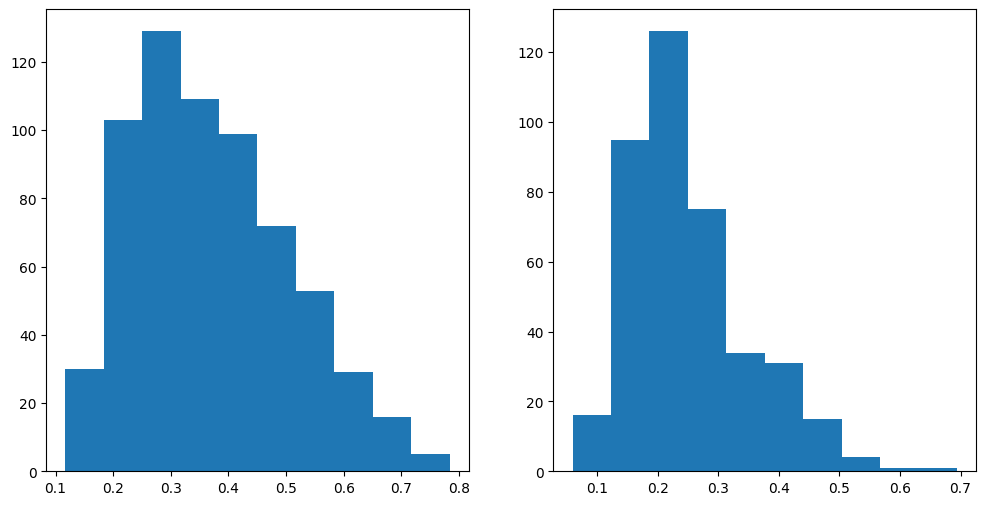

In [12]:
fg,ax = plt.subplots(1,2, figsize=(12,6))
ax[0].hist(np.array(
x_tr_val.todense()
).T[0][
np.array(x_tr).T[0]==np.arange(len(x_tr))
])
ax[1].hist(np.array(
x_tr_val.todense()
).T[0][
np.array(x_tr).T[0]!=np.arange(len(x_tr))
])

In [13]:
print

<function print(*args, sep=' ', end='\n', file=None, flush=False)>

(array([27., 46., 59., 74., 22.,  7.,  6.,  3.,  0.,  1.]),
 array([0.        , 0.04240849, 0.08481699, 0.12722548, 0.16963397,
        0.21204247, 0.25445096, 0.29685945, 0.33926795, 0.38167644,
        0.42408493]),
 <BarContainer object of 10 artists>)

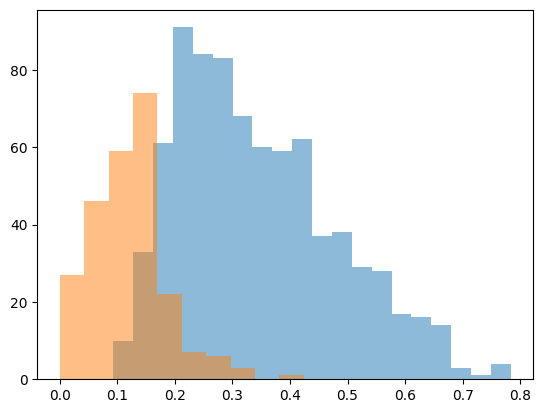

In [14]:
x_tr_tk = torch.topk(
torch.tensor((article_tnf_tr@title_tnf_tr.T).todense()), 3)
plt.hist(torch.concat([
x_tr_tk.values.T[0][
x_tr_tk.indices.T[0]==np.arange(len(x_tr_tk.values))],
x_tr_tk.values.T[1][
x_tr_tk.indices.T[1]==np.arange(len(x_tr_tk.values))],
x_tr_tk.values.T[2][
x_tr_tk.indices.T[2]==np.arange(len(x_tr_tk.values))]]),
alpha=.5, bins=20, label='Predictioned True Match')
msk = ~np.array([j in i for i,j in zip(torch.topk(
torch.tensor((article_tnf_tr@title_tnf_tr.T).todense()), 3).indices,
torch.arange(article_tnf_tr.shape[0]))])
plt.hist(
np.array(
    (article_tnf_tr@title_tnf_tr.T).todense())[
np.arange(len(msk))[msk],
np.arange(len(msk))[msk]], alpha=0.5, label='Predictioned False Match'
)

# above chart shows that we can set treshould on 0.2 on similarity score for  deciding on is title match with article or not

In [15]:
(article_tnf_tr==0).sum(),\
(title_tnf_tr==0).sum(),\
(article_tnf_tr!=0).sum(),\
(title_tnf_tr!=0).sum()

/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py:3553: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient, try using != instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


(np.int64(31344800), np.int64(31671292), np.int64(334239), np.int64(7747))

In [16]:
hdb = HDBSCAN(copy=True, min_cluster_size=5)
hdb.fit(article_tnf_tr)
set(hdb.labels_)

{np.int64(-1), np.int64(0), np.int64(1)}

In [17]:
lda = LatentDirichletAllocation(
    n_components=10,        # number of topics
    random_state=42,
    max_iter=10
)
lda.fit(article_cv_tr)

words = cv.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    top_words = [words[i] for i in topic.argsort()[-5:]]
    print(f"Topic {topic_idx}: {top_words}")

Topic 0: ['and', 'is', 'to', 'of', 'the']
Topic 1: ['is', 'you', 'and', 'the', 'to']
Topic 2: ['in', 'and', 'we', 'to', 'the']
Topic 3: ['in', 'and', 'of', 'to', 'the']
Topic 4: ['is', 'in', 'and', 'to', 'the']
Topic 5: ['and', 'in', 'to', 'of', 'the']
Topic 6: ['customer', 'sql', 'customerid', 'join', 'table']
Topic 7: ['table', 'run', 'and', 'to', 'the']
Topic 8: ['airflow', 'docker', 'selenium', 'to', 'the']
Topic 9: ['in', 'is', 'to', 'of', 'the']


In [18]:
nmf = LatentDirichletAllocation(
    n_components=10,        # number of topics
    random_state=42,
    max_iter=10
)
nmf.fit(article_tnf_tr)

words = cv.get_feature_names_out()
for topic_idx, topic in enumerate(nmf.components_):
    top_words = ' '.join([words[i] for i in topic.argsort()[-10:]])
    print(f"Topic {topic_idx}: {top_words}")

Topic 0: retirement omics milk backtesting impostor hypercolumn nadir bpdr wavelet capita
Topic 1: obama fantasy guitar expectancy neodti gnn tanking stylegan blackjack casino
Topic 2: hedgehog democrats pls panoptic bci t_ funnel obiee arauto emissions
Topic 3: you we that data is in and of to the
Topic 4: objectbox headless prob moderation fmin lanes cugraph cms nagisa listings
Topic 5: koalas pyro sam presidents troubleshooting olympic deception neo4j nifi stylecloud
Topic 6: ucb duck withcolumn timeseries cython kappa pyenv h3 auroc wine
Topic 7: ordinate valohai susan abhishek nbconvert subqueries actuarial lathe druid onnx
Topic 8: optimus args kinesis democratization deepstream christmas bokeh fingerprints newsletters nums
Topic 9: olist tal generalist kepler θ1 detectnet wandb cryptography ogrid starbucks


In [19]:
nmf = NMF(
    n_components=10,        # number of topics
    random_state=42,
    max_iter=10
)
article_nmf_tr = nmf.fit_transform(article_tnf_tr)

article_words = cv.get_feature_names_out()
for topic_idx, topic in enumerate(nmf.components_):
    top_words = ' '.join([article_words[i] for i in topic.argsort()[-10:]])
    print(f"Topic {topic_idx}: {top_words}")

Topic 0: it for this that is in and to of the
Topic 1: is what if my that and it your to you
Topic 2: that machine human intelligence learning in to of and ai
Topic 3: business is in scientist scientists of to and science data
Topic 4: function activation model images networks loss layer neural image network
Topic 5: in file you code pandas import and install to python
Topic 6: let features can that linear regression to model our we
Topic 7: and learning training machine ml to docker models the model
Topic 8: policy to environment agents actions the state reward action agent
Topic 9: sentiment to in reviews of nlp language word words text


/usr/local/lib/python3.12/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 10 reached. Increase it to improve convergence.
  warnings.warn(


In [20]:
nmf = NMF(
    n_components=10,        # number of topics
    random_state=42,
    max_iter=10
)
title_nmf_tr = nmf.fit_transform(title_tnf_tr)

title_words = cv.get_feature_names_out()
for topic_idx, topic in enumerate(nmf.components_):
    top_words = ' '.join([title_words[i] for i in topic.argsort()[-10:]])
    print(f"Topic {topic_idx}: {top_words}")

Topic 0: cancer exercise with for model classification part reinforcement learning machine
Topic 1: visualization job scientists tips for scientist how to science data
Topic 2: style understanding recurrent for pytorch optimization convolutional network networks neural
Topic 3: math frontier moneyball models logistic tensorflow assumptions basics linear regression
Topic 4: bioinformatics part vs how describing the winter ethics to ai
Topic 5: and started scraping image segmentation how using in with python
Topic 6: hyperparameters in space with intuition activation reinforcement models learning deep
Topic 7: trees convolutional how learn step tensorflow beginner complete to guide
Topic 8: in preprocessing computer vision to processing natural language introduction nlp
Topic 9: detection and future exploratory sentiment analysis of artificial intelligence the


/usr/local/lib/python3.12/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 10 reached. Increase it to improve convergence.
  warnings.warn(


In [21]:
title_words
title_words

array(['00', '000', '0000', ..., '𝑆𝑡𝑎𝑡𝑒', '𝑥₁', '𝑥₂'], dtype=object)

In [22]:
(torch.topk(torch.tensor(title_nmf_tr),3).indices),\
(torch.topk(torch.tensor(article_nmf_tr),3).indices)
# torch.topk(torch.tensor(article_nmf_tr),3)

(tensor([[4, 9, 5],
         [8, 6, 5],
         [2, 9, 6],
         ...,
         [5, 1, 9],
         [4, 9, 5],
         [1, 9, 5]]),
 tensor([[9, 0, 6],
         [9, 2, 0],
         [0, 2, 4],
         ...,
         [5, 1, 2],
         [0, 2, 6],
         [1, 0, 3]]))

In [23]:
# def tkn(x):
#     t = tokenizer(x.replace('\n\n','\n').split('\n'))

#     if max(list(map(len,t['input_ids'])))>255:
#         t = tokenizer(x.split('. '))

#         if max(list(map(len,t['input_ids'])))>255:
#             return tokenizer(x.split(' '))['input_ids']
#         else: 
#             return t['input_ids']
#     else: 
#         return t['input_ids']


# def agg_tkn(x):
#     a=[[101,0]]    
#     for n,i in enumerate(x):
#         if len(a[-1][:-1]+i[1:])<256:
#             # print(a[-1],i[1:])
#             a[-1][:-1]+=i[1:]
#             a[-1] = a[-1][:-1]
#         else:
#             a[-1]=torch.tensor(a[-1])
#             a+=[i]
#     a[-1]=torch.tensor(a[-1])
#     return a

In [24]:
nmf = NMF(n_components=10)
svd = TruncatedSVD(n_components=10)
lda = LatentDirichletAllocation(n_components=10)

In [25]:
words = tfidf.get_feature_names_out()

title_nmf = NMF(n_components=10).fit(title_tnf_tr)
articel_nmf = NMF(n_components=10).fit(article_tnf_tr)

for i in (articel_nmf.components_+title_nmf.components_):
    # print([words[j] for j in i.argsort()[-10:]])
    print(words[i.argsort()[-10:]])

['with' 'for' 'is' 'to' 'and' 'in' 'of' 'learning' 'machine' 'the']
['of' 'how' 'it' 'the' 'and' 'your' 'data' 'to' 'science' 'you']
['for' 'in' 'network' 'to' 'and' 'the' 'of' 'ai' 'networks' 'neural']
['scientists' 'in' 'the' 'science' 'of' 'to' 'and' 'linear' 'regression'
 'data']
['and' 'is' 'layer' 'neural' 'of' 'to' 'network' 'image' 'the' 'ai']
['you' 'code' 'install' 'using' 'with' 'in' 'and' 'the' 'to' 'python']
['of' 'that' 'is' 'in' 'and' 'our' 'to' 'learning' 'deep' 'we']
['training' 'beginner' 'data' 'is' 'complete' 'models' 'to' 'the' 'model'
 'guide']
['and' 'to' 'reward' 'state' 'action' 'of' 'artificial' 'intelligence'
 'agent' 'the']
['in' 'words' 'word' 'processing' 'natural' 'introduction' 'to' 'text'
 'language' 'nlp']


In [26]:
for j in [article_tnf_tr, title_tnf_tr, article_tnf_ts, title_tnf_ts]:
    nmf = NMF(n_components=10).fit(j)
    for topic_idx, topic in enumerate(nmf.components_):
        top_words = [words[i] for i in topic.argsort()[-5:]]
        print(f"Topic {topic_idx}: {top_words}")


Topic 0: ['and', 'to', 'in', 'of', 'the']
Topic 1: ['and', 'it', 'your', 'to', 'you']
Topic 2: ['to', 'and', 'the', 'of', 'ai']
Topic 3: ['of', 'science', 'to', 'and', 'data']
Topic 4: ['of', 'neural', 'network', 'image', 'the']
Topic 5: ['install', 'and', 'to', 'the', 'python']
Topic 6: ['and', 'that', 'our', 'to', 'we']
Topic 7: ['training', 'is', 'models', 'the', 'model']
Topic 8: ['state', 'reward', 'action', 'the', 'agent']
Topic 9: ['nlp', 'language', 'word', 'words', 'text']
Topic 0: ['reinforcement', 'classification', 'part', 'learning', 'machine']
Topic 1: ['scientist', 'how', 'to', 'science', 'data']
Topic 2: ['optimization', 'convolutional', 'network', 'networks', 'neural']
Topic 3: ['tensorflow', 'assumptions', 'basics', 'linear', 'regression']
Topic 4: ['the', 'ethics', 'winter', 'to', 'ai']
Topic 5: ['segmentation', 'using', 'in', 'with', 'python']
Topic 6: ['activation', 'reinforcement', 'models', 'learning', 'deep']
Topic 7: ['tensorflow', 'beginner', 'complete', 'to', 

In [27]:
article_nmf_tr = nmf.fit_transform(article_tnf_tr)
title_nmf_tr = nmf.fit_transform(title_tnf_tr)
article_nmf_ts = nmf.fit_transform(article_tnf_ts)
title_nmf_ts = nmf.fit_transform(title_tnf_ts)

nmf_x_tr = np.argmax(article_nmf_tr@title_nmf_tr.T,axis=1)
nmf_y_tr = np.argmax(article_nmf_tr@title_nmf_tr.T,axis=0)
nmf_x_ts = np.argmax(article_nmf_ts@title_nmf_ts.T,axis=1)
nmf_y_ts = np.argmax(article_nmf_ts@title_nmf_ts.T,axis=0)

(np.array(nmf_x_tr.T)==np.arange(len(x_tr))).sum()/len(x_tr),\
(np.array(nmf_y_tr)==np.arange(len(x_tr))).sum()/len(x_tr),\
(np.array(nmf_x_ts.T)==np.arange(len(x_ts))).sum()/len(x_ts),\
(np.array(nmf_y_ts)==np.arange(len(x_ts))).sum()/len(x_ts)

(np.float64(0.0019175455417066154),
 np.float64(0.0019175455417066154),
 np.float64(0.005747126436781609),
 np.float64(0.005747126436781609))

In [28]:
article_svd_tr = svd.fit_transform(article_tnf_tr)
title_svd_tr = svd.fit_transform(title_tnf_tr)
article_svd_ts = svd.fit_transform(article_tnf_ts)
title_svd_ts = svd.fit_transform(title_tnf_ts)

svd_x_tr = np.argmax(article_svd_tr@title_svd_tr.T,axis=1)
svd_y_tr = np.argmax(article_svd_tr@title_svd_tr.T,axis=0)
svd_x_ts = np.argmax(article_svd_ts@title_svd_ts.T,axis=1)
svd_y_ts = np.argmax(article_svd_ts@title_svd_ts.T,axis=0)

(np.array(svd_x_tr.T)==np.arange(len(x_tr))).sum()/len(x_tr),\
(np.array(svd_y_tr)==np.arange(len(x_tr))).sum()/len(x_tr),\
(np.array(svd_x_ts.T)==np.arange(len(x_ts))).sum()/len(x_ts),\
(np.array(svd_y_ts)==np.arange(len(x_ts))).sum()/len(x_ts)

(np.float64(0.0009587727708533077),
 np.float64(0.0),
 np.float64(0.005747126436781609),
 np.float64(0.0028735632183908046))